In [1]:
import scipy.io
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

import copy
import random
import math
import scipy
import time

from scipy.optimize import minimize
from numba import jit, njit

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# group = "senate"
# filename = f"/content/drive/My Drive/KPI/KPI навчання/5-6 курс/Дипломне проектування/Article replication/Data/processed data_{group}.mat"

# dataframe_mat = scipy.io.loadmat(filename)

In [2]:
group = "senate"
dataframe_mat = scipy.io.loadmat(f"Data/processed data_{group}.mat")

In [3]:
vote_rc = pd.DataFrame(
    data = dataframe_mat['V_rc'],
	index = [f"{i+1}" for i in range(len(dataframe_mat['V_rc']))], # 1st column as index
	columns = [f"{i+1}" for i in range(len(dataframe_mat['V_rc'][0]))] # 1st row as the column names
)
leader_rc = pd.DataFrame(
    data = dataframe_mat['leader_rc'],
	index = [f"{i+1}" for i in range(len(dataframe_mat['leader_rc']))], # 1st column as index
	columns = [f"{i+1}" for i in range(len(dataframe_mat['leader_rc'][0]))] # 1st row as the column names
)
whip_rc = pd.DataFrame(
    data = dataframe_mat['whip_rc'],
	index = [f"{i+1}" for i in range(len(dataframe_mat['whip_rc']))], # 1st column as index
	columns = [f"{i+1}" for i in range(len(dataframe_mat['whip_rc'][0]))] # 1st row as the column names
)
bigmajority_list = pd.DataFrame(
    data = dataframe_mat['bigmajority_list'],
	index = [f"{i+1}" for i in range(len(dataframe_mat['bigmajority_list']))], # 1st column as index
	columns = [f"{i+1}" for i in range(len(dataframe_mat['bigmajority_list'][0]))] # 1st row as the column names
)
party_list = pd.DataFrame(
    data = dataframe_mat['party_list'],
	index = [f"{i+1}" for i in range(len(dataframe_mat['party_list']))], # 1st column as index
	columns = [f"{i+1}" for i in range(len(dataframe_mat['party_list'][0]))] # 1st row as the column names
)
congress_list = pd.DataFrame(
    data = dataframe_mat['congress_list'],
	index = [f"{i+1}" for i in range(len(dataframe_mat['congress_list']))], # 1st column as index
	columns = [f"{i+1}" for i in range(len(dataframe_mat['congress_list'][0]))] # 1st row as the column names
)

### 1. Data Preproccessing

In [4]:
print(f"{group.upper()} statistics")
print("----------------")

congress_id, bills_per_congress = np.unique(congress_list.values, return_counts=True)
print(f"\nNumber of bills overall = {np.sum(bills_per_congress)} ({len(congress_id)} congresses, id: {np.min(congress_id)} - {np.max(congress_id)})")
print(f"Number of deputies overall = {party_list.size}")

congress_id_involved = 70
print(f"\nCongress id involved: {congress_id_involved}")

beginning_bills_in_congresses_involved = bills_per_congress[
    0:int(congress_id_involved - np.min(congress_id))
].sum()
ending_bills_in_congresses_involved = bills_per_congress[
    0:int(congress_id_involved - np.min(congress_id) + 1)
].sum()

vote_congress = vote_rc.iloc[:,beginning_bills_in_congresses_involved:ending_bills_in_congresses_involved].dropna(how='all')
vote_congress_array = np.array(vote_congress)

party_list_congress = party_list.loc[vote_congress.index]
party_list_congress_array = np.array(party_list_congress).flatten()

bigmajority_list_congress = bigmajority_list.loc[:,vote_congress.columns]
bigmajority_list_congress = pd.concat([bigmajority_list_congress]*len(vote_congress.index))
bigmajority_list_congress.index = vote_congress.index
bigmajority_list_congress_array = np.array(bigmajority_list_congress).flatten()

leader_rc_congress = leader_rc.loc[vote_congress.index,vote_congress.columns]
leader_rc_congress_array = np.array(leader_rc_congress)

whip_rc_congress = whip_rc.loc[vote_congress.index,vote_congress.columns]
whip_rc_congress_array = np.array(whip_rc_congress)

N = vote_congress.shape[0]
T = vote_congress.shape[1]

print(f"Number of bills in the congress = {T}")
print(f"Number of deputies in the congress = {N}")

SENATE statistics
----------------

Number of bills overall = 25825 (46 congresses, id: 70 - 115)
Number of deputies overall = 805

Congress id involved: 70
Number of bills in the congress = 191
Number of deputies in the congress = 101


In [5]:
vote_congress

,1,2,3,4,5,6,7,8,9,10,...,182,183,184,185,186,187,188,189,190,191
8,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,NaN,NaN,1.0,NaN,0.0,1.0,0.0,NaN
17,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
21,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0
30,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
31,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
417,1.0,1.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,NaN
418,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
420,1.0,1.0,0.0,1.0,1.0,0.0,NaN,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0
423,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,NaN,0.0,0.0,1.0,0.0,1.0,NaN


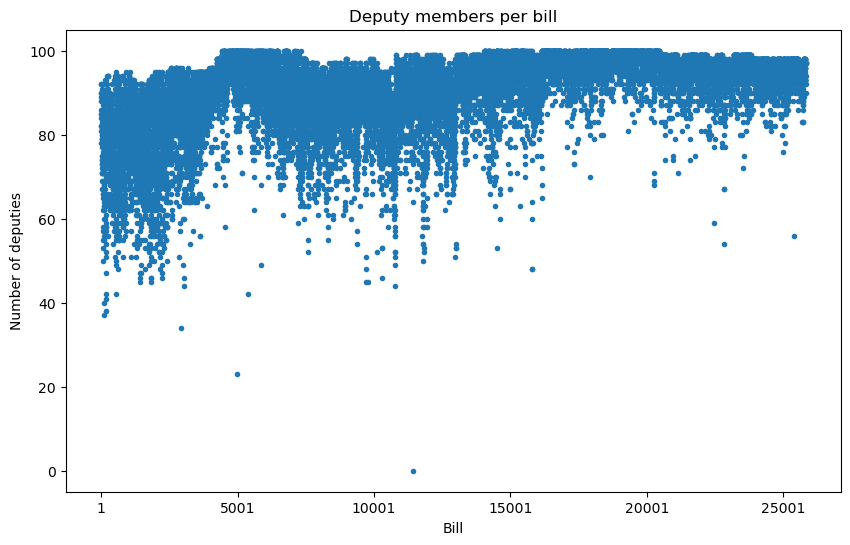

In [6]:
plt.figure(figsize=(10,6))
vote_rc.notna().sum().plot(title="Deputy members per bill", style=".", xlabel="Bill", ylabel="Number of deputies")
plt.show()

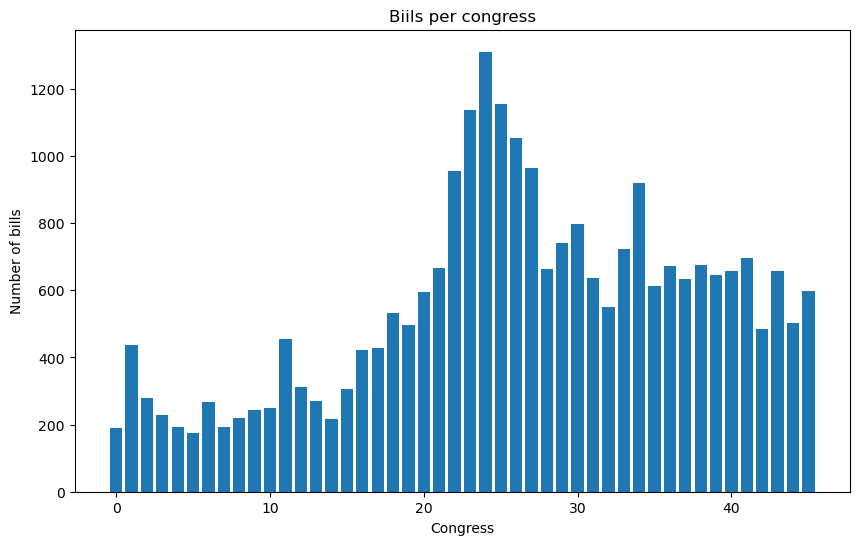

In [7]:
plt.figure(figsize=(10,6))
plt.bar(x=np.arange(0,len(bills_per_congress)), height=bills_per_congress)
plt.xlabel("Congress")
plt.ylabel("Number of bills")
plt.title("Biils per congress")
plt.show()

In [8]:
party_direction_congress = copy.deepcopy(leader_rc_congress)

print(f"Nans in party_direction: {party_direction_congress.isnull().sum().sum()}/{party_direction_congress.size}")

party_direction_congress.fillna(whip_rc_congress, inplace=True)
party_direction_congress.fillna(bigmajority_list_congress, inplace=True)

print(f"Nans after fillna: {party_direction_congress.isnull().sum().sum()}/{party_direction_congress.size}")

party_direction_congress_array = np.array(party_direction_congress)

Nans in party_direction: 1476/19291
Nans after fillna: 0/19291


### 2. Initial Guess

In [9]:
random.seed(112)

theta = np.array([[random.uniform(0,1),random.uniform(0,1)] for _ in range(N)])

# Normalize theta
theta = theta - theta[0]

if party_list_congress_array[0] == 100:
	# center Dems around 0 and GOP further right
	theta[1:] = [
		theta[i] - 0.5 if party_list_congress_array[i] == 100 else theta[i] + 0.5 
		for i in range(1,len(theta))
	]
else:
	# center GOP around 0 and Dems further left
	theta[1:] = [
		theta[i] - 1.5 if party_list_congress_array[i] == 100 else theta[i] - 0.5 
		for i in range(1,len(theta))
	]

# initialize ymax
ymax = np.array([random.uniform(0,1), random.uniform(0,1)])

# initialize cutlines for bills
m = np.array([1 - 2*random.uniform(0,1) for _ in range(T)])
b = np.array([1 - 2*random.uniform(0,1) for _ in range(T)])

# construct a big parameter vector
omega_initial_guess = np.concatenate([theta.flatten(), ymax, m, b])

print(f"Parameters of the model: {len(omega_initial_guess)}")

Parameters of the model: 586


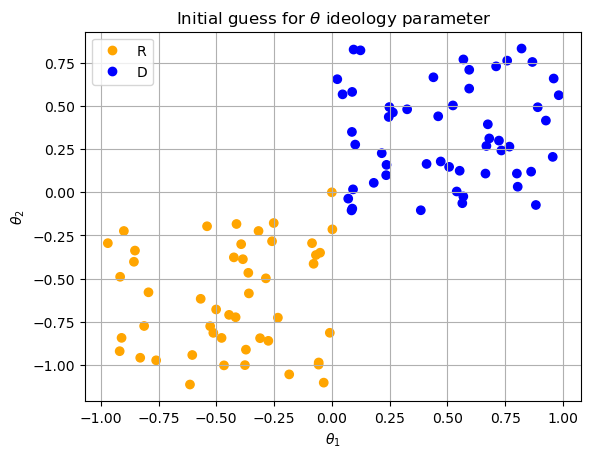

In [10]:
scatter = plt.scatter(
    x = [omega_initial_guess[0 + 2*deputy] for deputy in range(N)], 
    y = [omega_initial_guess[1 + 2*deputy] for deputy in range(N)],
    c = party_list_congress_array,
    cmap = ListedColormap(["orange","blue"])
)
plt.legend(handles=scatter.legend_elements()[0], labels=["R","D"])
plt.grid()
plt.xlabel(r"$\theta_1$")
plt.ylabel(r"$\theta_2$")
plt.title(r"Initial guess for $\theta$ ideology parameter")
plt.show()

### 3. Likelihood Optimization

In [11]:
def norm_cdf(x):
    # Cumulative distribution function for the standard normal distribution
    return (1.0 + math.erf(x / np.sqrt(2.0))) / 2.0

In [14]:
def neg_likelihood(omega):
	# Unpack (decompose) parameter vector
	theta = np.zeros((N,2))
	ymax = np.zeros(2)
	m = np.zeros(T)
	b = np.zeros(T)

	for deputy in range(N):
		theta[deputy][0], theta[deputy][1] = omega[0 + 2*deputy], omega[1 + 2*deputy]

	ymax[0], ymax[1] = omega[0 + 2*N], omega[1 + 2*N]

	for bill in range(T):
		m[bill], b[bill] = omega[2*N + 2 + bill], omega[2*N + 2 + T + bill]
  
	# Calculate likelihood value
	likelihood_value = 0

	for bill in range(T):
		for deputy in np.where(~np.isnan(vote_congress_array.T[bill]))[0]:			
			party_id = int(bool(party_list_congress_array[deputy] - 100)) # R for 1 (200), D for 0 (100)
			
			if party_direction_congress_array[deputy][bill] == 1.0:
				whip_party_pos = 1.0
				whip_party_neg = -1.0
			if party_direction_congress_array[deputy][bill] == 0.0:
				whip_party_pos = -1.0
				whip_party_neg = 1.0

			cdf_arg_pos = np.sqrt(1 / (1 + m[bill]**2)) * (
				theta[deputy][1] - m[bill]*theta[deputy][0] - b[bill] + whip_party_pos*ymax[party_id]
			)

			cdf_arg_neg = np.sqrt(1 / (1 + m[bill]**2)) * (
				theta[deputy][1] - m[bill]*theta[deputy][0] - b[bill] + whip_party_neg*ymax[party_id]
			)

			cdf_value_arg_pos = norm_cdf(cdf_arg_pos)
			cdf_value_arg_neg = norm_cdf(-cdf_arg_neg)

			likelihood_pos = vote_congress_array[deputy][bill] * np.log(cdf_value_arg_pos) + \
				(1 - vote_congress_array[deputy][bill]) * np.log(1 - cdf_value_arg_pos)
			likelihood_neg = vote_congress_array[deputy][bill] * np.log(cdf_value_arg_neg) + \
				(1 - vote_congress_array[deputy][bill]) * np.log(1 - cdf_value_arg_neg)
			
			# logcdf_value_arg_pos = scipy.stats.norm.logcdf(cdf_arg_pos)
			# logsf_value_arg_pos = scipy.stats.norm.logsf(cdf_arg_pos)

			# logcdf_value_arg_neg = scipy.stats.norm.logcdf(cdf_arg_neg)
			# logsf_value_arg_neg = scipy.stats.norm.logsf(cdf_arg_neg)

			# likelihood_pos = vote_congress_array[deputy][bill] * logcdf_value_arg_pos + \
			# 	(1 - vote_congress_array[deputy][bill]) * logsf_value_arg_pos
			# likelihood_neg = vote_congress_array[deputy][bill] * logsf_value_arg_neg + \
			# 	(1 - vote_congress_array[deputy][bill]) * logcdf_value_arg_neg

			likelihood_value += max(likelihood_pos,likelihood_neg)

	return -likelihood_value

In [15]:
start_time = time.time()
print(f"Log(L) = {neg_likelihood(omega_initial_guess)}")
end_time = time.time()
print(f"Time of one execution = {round(end_time-start_time,4)} s")

Log(L) = 5248.5360145342365
Time of one execution = 0.243 s


In [ ]:
result = minimize(
	fun = neg_likelihood,
	x0 = omega_initial_guess,
	method = "SLSQP", # "SLSQP", "Nelder-Mead"
    options = {"maxiter": 1000}
)

In [127]:
result

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 37.68231743307773
       x: [ 4.019e+00  1.505e+00 ... -7.817e-01 -7.930e-01]
     nit: 57
     jac: [-1.942e-02 -1.343e-02 ...  1.995e-02  6.875e-03]
    nfev: 33699
    njev: 57

Distance between party centroids = 8.2188


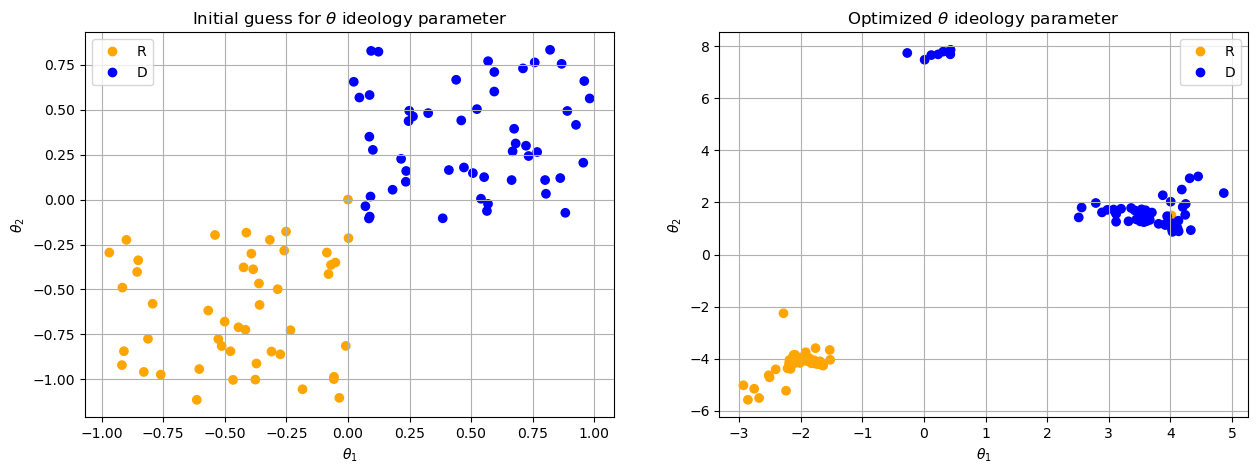

In [128]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
scatter = plt.scatter(
    x = [omega_initial_guess[0 + 2*deputy] for deputy in range(N)], 
    y = [omega_initial_guess[1 + 2*deputy] for deputy in range(N)],
    c = party_list_congress_array,
    cmap = ListedColormap(["orange","blue"])
)
plt.legend(handles=scatter.legend_elements()[0], labels=["R","D"])
plt.grid()
plt.xlabel(r"$\theta_1$")
plt.ylabel(r"$\theta_2$")
plt.title(r"Initial guess for $\theta$ ideology parameter")

omega_hat = result.x
theta_1_R = [omega_hat[0 + 2*deputy] for deputy in range(N) if party_list_congress_array[deputy] == 100]
theta_2_R = [omega_hat[1 + 2*deputy] for deputy in range(N) if party_list_congress_array[deputy] == 100]
R_party_centroid = np.array([np.mean(theta_1_R),np.mean(theta_2_R)])

theta_1_D = [omega_hat[0 + 2*deputy] for deputy in range(N) if party_list_congress_array[deputy] == 200]
theta_2_D = [omega_hat[1 + 2*deputy] for deputy in range(N) if party_list_congress_array[deputy] == 200]
D_party_centroid = np.array([np.mean(theta_1_D),np.mean(theta_2_D)])

distance_between_party_centroids = np.sqrt(np.sum(np.square(R_party_centroid - D_party_centroid)))
print(f"Distance between party centroids = {round(distance_between_party_centroids, 4)}")

plt.subplot(1,2,2)
scatter = plt.scatter(
    x = [omega_hat[0 + 2*deputy] for deputy in range(N)], 
    y = [omega_hat[1 + 2*deputy] for deputy in range(N)],
    c = party_list_congress_array,
    cmap = ListedColormap(["orange","blue"])
)
plt.legend(handles=scatter.legend_elements()[0], labels=["R","D"])
plt.grid()
plt.xlabel(r"$\theta_1$")
plt.ylabel(r"$\theta_2$")
plt.title(r"Optimized $\theta$ ideology parameter")

plt.show()

In [129]:
x = 1.96

print("Erf       =", norm_cdf(x), np.log(norm_cdf(x)))
print("Scipy     =", scipy.stats.norm.cdf(x), np.log(scipy.stats.norm.cdf(x)))
print("Log Scipy =", scipy.stats.norm.cdf(x), scipy.stats.norm.logcdf(x))

Erf       = 0.9750021048517796 -0.02531564916428205
Scipy     = 0.9750021048517795 -0.025315649164282163
Log Scipy = 0.9750021048517795 -0.02531564916428212


In [130]:
x = 30

print("Erf       =", norm_cdf(x), np.log(norm_cdf(x)))
print("Scipy     =", scipy.stats.norm.cdf(x), np.log(scipy.stats.norm.cdf(x)))
print("Log Scipy =", scipy.stats.norm.cdf(x), scipy.stats.norm.logcdf(x))

Erf       = 1.0 0.0
Scipy     = 1.0 0.0
Log Scipy = 1.0 -4.906713927147908e-198


In [131]:
x = 1.96

print("Erf       =", 1 - norm_cdf(x), np.log(1 - norm_cdf(x)))
print("Scipy     =", 1 - scipy.stats.norm.cdf(x), np.log(1 - scipy.stats.norm.cdf(x)))
print("Log Scipy =", 1 - scipy.stats.norm.cdf(x), scipy.stats.norm.logcdf(-x))
print("Log Scipy =", 1 - scipy.stats.norm.cdf(x), scipy.stats.norm.logsf(x))

Erf       = 0.024997895148220373 -3.688963651729641
Scipy     = 0.024997895148220484 -3.6889636517296367
Log Scipy = 0.024997895148220484 -3.6889636517296385
Log Scipy = 0.024997895148220484 -3.6889636517296385


In [ ]:
x = 1000

print("Erf       =", 1 - norm_cdf(x), np.log(1 - norm_cdf(x)))
print("Scipy     =", 1 - scipy.stats.norm.cdf(x), np.log(1 - scipy.stats.norm.cdf(x)))
print("Log Scipy =", 1 - scipy.stats.norm.cdf(x), scipy.stats.norm.logcdf(-x))
print("Log Scipy =", 1 - scipy.stats.norm.cdf(x), scipy.stats.norm.logsf(x))